In [29]:
import requests
import math
import numpy as np
from astropy.time import Time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#plt.rc('font', family='DejaVu Sans', serif='Times')
#plt.rc('text', usetex=True)
from pprint import pprint
from datetime import datetime

This API provides access to the JPL/SSD small-body mission design suite. The following operation modes are available:

* Mode A (accessible) - retrieves the list of accessible small bodies based on user-defined constraint.
* Mode Q (query) - retrieves pre-computed mission options to a specific object. Both impulsive and low-thrust gravity-assist mission options are available.
* Mode M (map) - an extension of mode Q for the impulsive case, returns the data required to render a porkchop plot with multiple parameters.
* Mode T (mission extension) - retrieves the list of small bodies that come closest (or within a prescribed distance) to a user-defined orbit during a certain period of time. This is a crude filter for finding potential candidates for mission extensions.

This script emphazise the development of the following mode

* Mode M - In addition to querying the database like in mode Q (ballistic), compute all ballistic mission options to the specified target within certain ranges of launch dates and times of flight.
    * In addition, the values of the x-_y_ axes of the maps are also provided:
        * dep_date - departure dates from Earth (Modified Julian Date), corresponding to the x-axis.
        * tof - times of flight to the target (days), corresponding to the y-axis.
        * If dep_date has m elements and tof has n, then the 2D arrays are of dimension n x m.
        * vinf_dep
        * vinf_arr

[Reference of the API construction, data input and output](https://ssd-api.jpl.nasa.gov/doc/mdesign.html)

# Single example Query 

In [ ]:
url_base = 'https://ssd-api.jpl.nasa.gov/mdesign.api'
asteroid_name = '2012TC4' # designation (provisional or IAU-number) of the desired object (e.g., 2015 AB or 141P or 433).
                         # NOTE: when submitting a des containing a space in your query string, you must 
                         # replace the space with %20, for example 2015%20AB.
mjd0 = 59215            # 21Jan2021 # first launch date to be explored (Modified Julian Date)
span = 365                # duration of the launch-date period to be explored (days)
tof_min = 50          # minimum time of flight to be considered (days)
tof_max = 720       # maximum time of flight to be considered (days)
step = 5            # time step used to advance both the launch date and the time of flight (days). 
                    # The size of the transfer map is limited to 1,500,000 points

sim_lim_points = 1500000 #1.5 millions
if int(span)/int(step) > sim_lim_points:
    print('outside of tool limits') 

url = f'{url_base}?sstr={str(asteroid_name)}&mjd0={str(mjd0)}&span={str(span)}&tof-min={str(tof_min)}&tof-max={str(tof_max)}&step={str(step)}'
r = requests.get(url)

data = r.json()

print(data)

# Functions

In [2]:
def get_mission_profiles(asteroid_name,mjd0,span,tof_min,tof_max,step):
    # asteroid_name:    designation (provisional or IAU-number) of the desired object (e.g., 2015 AB or 141P or 433).
    #                   NOTE: when submitting a des containing a space in your query string, you must replace the space with %20, for example 2015%20AB
    # mjd0:             first launch date to be explored (Modified Julian Date)
    # span:             duration of the launch-date period to be explored (days)
    # tof-min:          minimum time of flight to be considered (days)
    # tof-max:          maximum time of flight to be considered (days)
    # step:             time step used to advance both the launch date and the time of flight (days). 
                        
    # The size of the transfer map is limited to 1,500,000 points
    sim_lim_points = 1500000 #1.5 millions
    if int(span)/int(step) > sim_lim_points:
        print('outside of tool limits') # TODO return error
    
    # Construction of the HTTP request
    url_base = 'https://ssd-api.jpl.nasa.gov/mdesign.api'
    url = f'{url_base}?sstr={str(asteroid_name)}&mjd0={str(mjd0)}&span={str(span)}&tof-min={str(tof_min)}&tof-max={str(tof_max)}&step={str(step)}'
    r = requests.get(url)
    data = r.json()

    # Elaboration of data
    available_missions = len(data['selectedMissions'])
    mission_profiles={};
    mjd01Jan2021 = 59215
    mjd01Jan2048 = 69076
    j = 0
    for mission_id in range(available_missions):
        if (data["selectedMissions"][mission_id][0] > mjd01Jan2021 and data["selectedMissions"][mission_id][1] < mjd01Jan2048):
            sel_profile={"fullname": data["object"]["fullname"],
                      "mjd0": data["selectedMissions"][mission_id][0],
                      "mjdf": data["selectedMissions"][mission_id][1],
                      "tof": data["selectedMissions"][mission_id][9],
                      "vinf_dep": data["selectedMissions"][mission_id][2],
                      "vinf_arr": data["selectedMissions"][mission_id][3],
                      "earth_dist": data["selectedMissions"][mission_id][5],
                      "phase_ang": data["selectedMissions"][mission_id][4], 
                      "elong_arr": data["selectedMissions"][mission_id][6], 
                      "decl_dep": data["selectedMissions"][mission_id][7],
                      "approach_ang": data["selectedMissions"][mission_id][8],      
                     };
            mission_profiles[str(j)]=sel_profile;
            j = j+1
    
    # Find min dv mission profile
    mission_profile_min_dv, mp_dv_plot = get_min_dv_mission_profile(mission_profiles);
    
    # Porkchop data
    porkchop_dv, dep_date, tof, pc_plot = get_mission_porkchop(data);
    
    return mission_profiles, porkchop_dv, dep_date, tof, pc_plot, mission_profile_min_dv, mp_dv_plot
    #return mission_profiles

In [3]:
def get_min_dv_mission_profile(mission_profiles):
     # Find the best Mission Profile
    dv = np.zeros(len(mission_profiles.keys()))
    for profile in range(len(mission_profiles)):
        dv[profile] = mission_profiles[str(profile)]['vinf_dep'] + mission_profiles[str(profile)]['vinf_arr']

    index = np.linspace(0,len(dv)-1,len(dv))
    mask = [dv == np.min(dv)]
    idx_min = index[tuple(mask)]
    if type(idx_min) == float:
        mission_profile_min_dv = mission_profiles[str(int(idx_min))]
    else:
        #val, idx_min = min((val, idx) for (idx, val) in enumerate(dv))
        mission_profile_min_dv = mission_profiles[str(int(idx_min[0]))] # NOTE: there could be more than one best solution, here i took arbitrarly the first
    
    # Plot of the mission profiles and highlight the best one
    fig = plt.figure()
    plt.plot(dv, "*");
    fig.suptitle('Mission Profile dv Distribution for '+ mission_profile_min_dv["fullname"])
    plt.xlabel('$idx$ (-)')
    plt.ylabel('$dv$ (km/s)')
    plt.plot(int(idx_min[0]), dv[int(idx_min[0])], "r+");
    
    return mission_profile_min_dv, fig

In [39]:
def get_mission_porkchop(data):
    # to pass mjd2000 to date format
    dep_date=Time(data["dep_date"], format='mjd').to_value('iso', 'date');
    tof=data["tof"];
    
    # Elaboration of data
    m = len(data["dep_date"])
    n = len(data["tof"])
    porkchop_map = np.zeros([n,m]) # porkchop_map[i,j]
    for i in range(n):
        for j in range(m):
            porkchop_map[i,j]=abs(data["vinf_arr"][i][j])+abs(data["vinf_dep"][i][j])
    
    # Porchop Plot
    #fig, ax = plt.subplots()
    fig = plt.figure()
    plt.contour(dep_date, tof, porkchop_map, np.linspace(0,50,51), cmap="gnuplot") # arbitrary max contour level at dv = 50 km/s
    fig.suptitle('Porkchop Plot for '+ data["object"]["fullname"])
    plt.xlabel('$Date_{dep}$ (-)')
    plt.ylabel('$ToF$ (d)')       
    plt.colorbar()
    
    locator = mdates.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    
    plt.gcf().autofmt_xdate()

    # date as xtick 
    # Major ticks every 6 months.
    # fmt_half_year = mdates.MonthLocator(interval=6)
    # ax.xaxis.set_major_locator(fmt_half_year)
    # Minor ticks every month.
    # fmt_month = mdates.MonthLocator()
    # ax.xaxis.set_minor_locator(fmt_month)
    # Text in the x axis will be displayed in 'YYYY-mm' format.
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    # Rotates and right aligns the x labels, and moves the bottom of the axes up to make room for them.
    #fig.autofmt_xdate()
    
    return porkchop_map, dep_date, tof, fig

In [ ]:
##### DO NOT RUN NOW, TO CHECK THE USE


# Mode T - Request list of small bodies that come closest (or within a prescribed distance) to a user-specified heliocentric 
# orbit (assumes two-body dynamics). Proxy for easiest-to-reach targets for an extended mission phase.
# example url
# https://ssd-api.jpl.nasa.gov/mdesign.api?ec=0.2056408220896557&qr=0.3074958016246215&tp=2459067.6508400026&
# om=48.30597718083336&w=29.18348714438387&in=7.003733902930839&jd0=2458849.5&jdf=2459132.5&maxout=100&maxdist=0.0010

def get_close_approach_to_asteroid(orb_params,jd0,jdf,n_object_requested,distance_within):
    # orb_params:            array containing the orbital parameters required to run the query
    #     ec:                eccentricity [>0]
    #     qr:                perihelion distance [>0]
    #     tp:                time of perihelion passage (JD)
    #     OM:                longitude of the ascending node (deg) [0,360]
    #     om:                argument of periapsis (deg) [0,360]
    #     incl:              inclination (deg) [0,180]
    # jd0:                   beginning of the requested time span (JD)
    # jdf:                   end of the requested time span (JD). Time span must not be longer than one year
    # n_object_requested:    maximum number of records to be returned
    # distance_within:       ignore objects with distance of closest approach greater than "distance_within" [>0, optional]
    
    # Extraction of inputs
    ec = orb_params[1]
    qr = orb_params[2]
    tp = orb_params[3]
    OM = orb_params[4]
    om = orb_params[5]
    incl = orb_params[6]
    
    # Construction of the HTTP request
    url_base = 'https://ssd-api.jpl.nasa.gov/mdesign.api'
    url = f'{url_base}?ec={str(ec)}&qr={str(qr)}&tp={str(tp)}&om={str(OM)}&w={str(om)}&in={str(incl)}&jd0={str(jd0)}&jdf={str(jdf)}&maxout={str(n_object_requested)}&maxdist={str(distance_within)}'
    r = requests.get(url)
    data = r.json()
    return data

# Function Call

In [19]:
 # example to show that actually 2012qd8 works
url_base = 'https://ssd-api.jpl.nasa.gov/mdesign.api'
url = f'{url_base}?sstr=2012QD8&mjd0={str(59215)}&span={str(365)}&tof-min={str(50)}&tof-max={str(700)}&step={str(5)}'
r = requests.get(url)
data = r.json()
available_missions = len(data['selectedMissions'])
mission_profiles={};
mjd01Jan2021 = 59215
mjd01Jan2048 = 69076


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [28]:
mjd01Jan2048 = 69076
Time(mjd01Jan2048, format='mjd').to_value('iso', 'date')

'2048-01-01'

In [20]:
mission_profiles
Time(data["dep_date"], format='mjd').to_value('iso', 'date')

{}

In [34]:
dep_date_2012tc4

array(['2021-01-01', '2021-01-06', '2021-01-11', '2021-01-16',
       '2021-01-21', '2021-01-26', '2021-01-31', '2021-02-05',
       '2021-02-10', '2021-02-15', '2021-02-20', '2021-02-25',
       '2021-03-02', '2021-03-07', '2021-03-12', '2021-03-17',
       '2021-03-22', '2021-03-27', '2021-04-01', '2021-04-06',
       '2021-04-11', '2021-04-16', '2021-04-21', '2021-04-26',
       '2021-05-01', '2021-05-06', '2021-05-11', '2021-05-16',
       '2021-05-21', '2021-05-26', '2021-05-31', '2021-06-05',
       '2021-06-10', '2021-06-15', '2021-06-20', '2021-06-25',
       '2021-06-30', '2021-07-05', '2021-07-10', '2021-07-15',
       '2021-07-20', '2021-07-25', '2021-07-30', '2021-08-04',
       '2021-08-09', '2021-08-14', '2021-08-19', '2021-08-24',
       '2021-08-29', '2021-09-03', '2021-09-08', '2021-09-13',
       '2021-09-18', '2021-09-23', '2021-09-28', '2021-10-03',
       '2021-10-08', '2021-10-13', '2021-10-18', '2021-10-23',
       '2021-10-28', '2021-11-02', '2021-11-07', '2021-

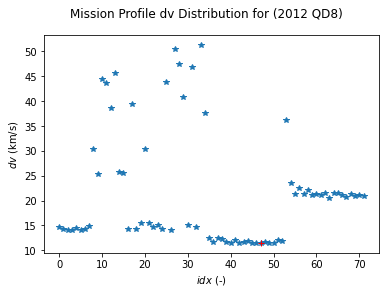

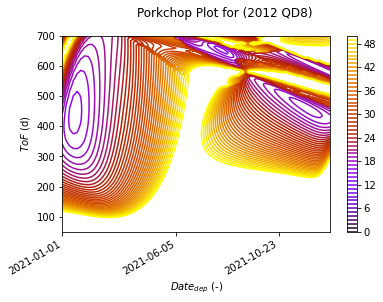

In [40]:
# single asteroid
req_ast_name = '2012QD8'
req_mjd0 = 59215
req_duration = 365
req_min_tof = 50
req_max_tof = 700
req_step_size = 5

missions_2012tc4, porkchop_dv_2012tc4, dep_date_2012tc4, tof_2012tc4, pc_plot_2012tc4, mp_min_dv_2012tc4, mp_dv_plot_2012tc4 = get_mission_profiles(req_ast_name,req_mjd0,req_duration,req_min_tof,req_max_tof,req_step_size)
#missions_2012tc4 = get_mission_profiles(req_ast_name,req_mjd0,req_duration,req_min_tof,req_max_tof,req_step_size)
#missions_2012tc4

In [ ]:
mission_stuff, porkchop_dv_stuff, dep_date_stuff, tof_stuff, pc_plot_stuff, mp_min_dv_stuff, mp_dv_plot_stuff = \
    get_mission_profiles(req_ast_name[0],req_mjd0,req_duration,req_min_tof,req_max_tof,req_step_size)

In [ ]:
# list of asteroids name
# req_ast_name = ['2012QD8','2005WG57','2012BY1','2012SY49','2008XU2','2008KN11','2020UE','2006HX57','2006SC']
req_ast_name = ['2005WG57','2012BY1']
req_mjd0 = 59366 # 01 Jun 2021
req_duration = 2405 # days till 01 Jan 2028, end of launch time window
req_min_tof = 50 # blind
req_max_tof = 720 # blind
req_step_size = 50
#missions={}
for asteroid in range(len(req_ast_name)):
    mission[asteroid] = get_mission_profiles(req_ast_name[asteroid],req_mjd0,req_duration,req_min_tof,req_max_tof,req_step_size)
    
    #stuff={"mission_profiles": mission_profiles,
          #"porkchop_dv": porkchop_dv,
          #"dep_date": dep_date,
          #"tof": tof,
          #"pc_plot": pc_plot,
          #"mp_min_dv": mp_min_dv,
          #"mp_dv_plot": mp_dv_plot,    
         #};
   # missions[asteroid]=stuff;



# Mode A

In [16]:
def get_accessible_sb(records_lim,optim_crit,years,sb_class,rdzvs,profile,ball_flag,lt_flag):
    # If ballistic missions are requested, the API expects crit to be defined. 
    # If low-thrust missions are requested, the API expects profile and rdzvs to be defined.
    
    ## INPUT
    # lim:         number of records to be retrieved form the SBDB
    # crit:        optimality criterion for selecting ballistic missions: 
    #              1) min. departure V-infinity, 
    #              2) min. arrival V-infinity, 
    #              3) min. total delta-V, 
    #              4) min. tof + min. departure V-infinity, 
    #              5) min. tof + min. arrival V-infinity, 
    #              6) min. tof + min. total delta-V
    # year:        launch year or list of launch years for which optimal missions are to be retrieved 
    #              from the SBDB [current year + [0, 20]]
    # rdzvs        when requesting low-thrust missions, if rdzvs is true, only rendezvous missions are retrieved from the SBDB. 
    #              If false, flyby missions will be retrieved [boolean]
    # profile      when requesting low-thrust missions, profile maps to the spacecraft configuration: 
    #              1) Mid-size spacecraft, 2) smallsat
    
    ## OUTPUT BALLISTIC
    # name - small-body full name.
    # date0 - departure date (cal).
    # MJD0 - departure date (MJD).
    # datef - arrival date (cal).
    # MJDF - arrival date (MJD).
    # c3_dep - departure characteristic energy C3 (km^2/s^2).
    # vinf_dep - departure V-infinity (km/s).
    # vinf_arr - arrival V-infinity (km/s).
    # dv_tot - total delta-V (km/s).
    # tof - time of flight (d).
    # class - three-letter orbit class code.
    # H - absolute magnitude.
    # condition_code - orbit condition code.
    # neo - Near-Earth Object flag.
    # pha - Potentially-Hazardous Asteroid flag.
    # bin - binary flag.
    # pdes - designation.
    
    ## OUTPUT RENDEZ-VOUS
    # name - small-body full name.
    # date0 - departure date (cal).
    # MJD0 - departure date (MJD).
    # datef - arrival date (cal).
    # MJDF - arrival date (MJD).
    # c3_dep - departure characteristic energy C3 (km^2/s^2).
    # vinf_dep - departure V-infinity (km/s).
    # vinf_arr - arrival V-infinity (km/s).
    # mass_dep - departure mass.
    # mass_arr - arrival mass.
    # tof - time of flight (d).
    # nga - number of Earth gravity assists.
    # rdzvs - rendezvous flag.
    # class - three-letter orbit class code.
    # H - absolute magnitude.
    # condition_code - orbit condition code.
    # neo - Near-Earth Object flag.
    # pha - Potentially-Hazardous Asteroid flag.
    # bin - binary flag.
    # pdes - designation.
    
    url_base = 'https://ssd-api.jpl.nasa.gov/mdesign.api'
    
    if (ball_flag==1 and lt_flag == 0): # ballistic profile mission requested
        # https://ssd-api.jpl.nasa.gov/mdesign.api?lim=200&crit=1&year=2025,2026,2027,2028,2029&sb_group=neo
        # Construction of the HTTP request
        url = f'{url_base}?lim={str(records_lim)}&crit={str(optim_crit)}&year={str(years)}&sb_group={str(sb_class)}'
    elif (ball_flag == 0 and lt_flag == 1): # low thrust profile mission requested
        # https://ssd-api.jpl.nasa.gov/mdesign.api?lim=200&rdzvs=true&profile=1&year=2025,2026,2027,2028,2029&sb_class=TJN
        # Construction of the HTTP request
        url = f'{url_base}?lim={str(records_lim)}&rdzvs={str(rdzvs)}&profile={str(profile)}&year={str(years)}&sb_class={str(sb_class)}'
        
    r = requests.get(url)
    data = r.json()
    
    # Elaboration of data
    accessible_valid_sb={};
    # Definition of limit condition to consider valid small body among the accessible ones
    mjd31Dec2028 = 62136
    mjd01Jan2048 = 69076
    lim_magnitude = 28
    lim_OCC = 7
    lim_c3_dep = 15 # km^2/s^2
    
    if (ball_flag==1 and lt_flag == 0): # ballistic profile mission requested
        j = 0
        for accessible_sb in range(int(data['md_constraints']['lim'])):
            if (int(data['data'][accessible_sb][2]) < mjd31Dec2028 and int(data['data'][accessible_sb][4]) < mjd01Jan2048 and float(data['data'][accessible_sb][11]) < lim_magnitude and int(data['data'][accessible_sb][12]) < lim_OCC and float(data['data'][accessible_sb][5]) < lim_c3_dep):
                valid_sb={"fullname": data['data'][accessible_sb][0],
                          "mjd0": data['data'][accessible_sb][2],
                          "mjdf": data['data'][accessible_sb][4],
                          "c3_dep": data['data'][accessible_sb][5],
                          "vinf_dep": data['data'][accessible_sb][6],
                          "vinf_arr": data['data'][accessible_sb][7],
                          "dv_tot": data['data'][accessible_sb][8],
                          "tof": data['data'][accessible_sb][9],
                          "class": data['data'][accessible_sb][10],
                          "H": data['data'][accessible_sb][11],
                          "condition_code": data['data'][accessible_sb][12],
                          };
                accessible_valid_sb[str(j)]=valid_sb;
                j = j+1
    elif (ball_flag == 0 and lt_flag == 1): # low thrust profile mission requested
        j = 0
        for accessible_sb in range(int(data['md_constraints']['lim'])):
            if (int(data['data'][accessible_sb][2]) < mjd31Dec2028 and int(data['data'][accessible_sb][4]) < mjd01Jan2048 and float(data['data'][accessible_sb][14]) < lim_magnitude and int(data['data'][accessible_sb][15]) < lim_OCC and float(data['data'][accessible_sb][5]) < lim_c3_dep):
                valid_sb={"fullname": data['data'][accessible_sb][0],
                          "mjd0": data['data'][accessible_sb][2],
                          "mjdf": data['data'][accessible_sb][4],
                          "c3_dep": data['data'][accessible_sb][5],
                          "vinf_dep": data['data'][accessible_sb][6],
                          "vinf_arr": data['data'][accessible_sb][7],
                          "mass_dep": data['data'][accessible_sb][8],
                          "mass_arr": data['data'][accessible_sb][9],
                          "tof": data['data'][accessible_sb][10],
                          "nga": data['data'][accessible_sb][11],
                          "rdzvs": data['data'][accessible_sb][12],
                          "class": data['data'][accessible_sb][13],
                          "H": data['data'][accessible_sb][14],
                          "condition_code": data['data'][accessible_sb][15],
                          };
                accessible_valid_sb[str(j)]=valid_sb;
                j = j+1        

    return accessible_valid_sb

In [36]:
def get_min_dv_accessible_sb(accessible_valid_sb):
    # Find the best Mission Profile among the valid accessible small bodies
    dv = np.zeros(len(accessible_valid_sb.keys()))
    for profile in range(len(accessible_valid_sb)):
        dv[profile] = accessible_valid_sb[str(profile)]['dv_tot']

    index = np.linspace(0,len(dv)-1,len(dv))
    mask = [dv == np.min(dv)]
    idx_min = index[tuple(mask)]
    if type(idx_min) == float:
        accessible_sb_min_dv = accessible_valid_sb[str(int(idx_min))]
    else:
        #val, idx_min = min((val, idx) for (idx, val) in enumerate(dv))
        accessible_sb_min_dv = accessible_valid_sb[str(int(idx_min[0]))] # NOTE: there could be more than one best solution, here i took arbitrarly the first
    
    # Plot of the mission profiles and highlight the best one
    fig = plt.figure()
    plt.plot(dv, "*");
    fig.suptitle('Accessible Small Bodies Mission dv, and the minimum is ' + accessible_sb_min_dv["fullname"])
    plt.xlabel('$idx$ (-)')
    plt.ylabel('$dv$ (km/s)')
    plt.plot(int(idx_min[0]), dv[int(idx_min[0])], "r+");
    
    return accessible_sb_min_dv, fig

In [81]:
records_lim = 100
optim_crit = 3 # meaningfull only if ballistic profile
years = ','.join(map(str, np.linspace(2021,2048,2048-2021+1,dtype=int)))
sb_class = 'pha'
rdzvs = False # meaningfull only if low thrust profile
profile = 0 # meaningfull only if low thrust profile
ball_flag = 1
lt_flag = 0

data = get_accessible_sb(records_lim,optim_crit,years,sb_class,rdzvs,profile,ball_flag,lt_flag)

In [82]:
data

{'0': {'fullname': '363305 (2002 NV16)',
  'mjd0': '60579',
  'mjdf': '60829',
  'c3_dep': 11.53621225,
  'vinf_dep': '3.3965',
  'vinf_arr': '0.3038',
  'dv_tot': '3.7003',
  'tof': '250',
  'class': 'APO',
  'H': '21.4',
  'condition_code': '0'},
 '1': {'fullname': '(2015 HV182)',
  'mjd0': '60609',
  'mjdf': '61194',
  'c3_dep': 9.37829376,
  'vinf_dep': '3.0624',
  'vinf_arr': '1.0818',
  'dv_tot': '4.1442',
  'tof': '585',
  'class': 'APO',
  'H': '21.5',
  'condition_code': '3'},
 '2': {'fullname': '89136 (2001 US16)',
  'mjd0': '60084',
  'mjdf': '60744',
  'c3_dep': 12.14243716,
  'vinf_dep': '3.4846',
  'vinf_arr': '0.9416',
  'dv_tot': '4.4263',
  'tof': '660',
  'class': 'APO',
  'H': '20.2',
  'condition_code': '0'},
 '3': {'fullname': '341843 (2008 EV5)',
  'mjd0': '59749',
  'mjdf': '60309',
  'c3_dep': 1.76916601,
  'vinf_dep': '1.3301',
  'vinf_arr': '3.1844',
  'dv_tot': '4.5145',
  'tof': '560',
  'class': 'ATE',
  'H': '20.0',
  'condition_code': '1'},
 '4': {'fullna

In [74]:
len(data)

48

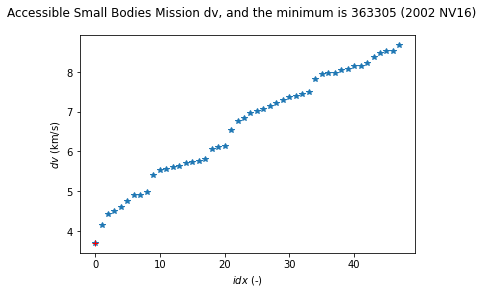

In [75]:
accessible_sb_min_dv, accessible_sb_dv_plot = get_min_dv_accessible_sb(data)

In [76]:
accessible_sb_min_dv

{'fullname': '363305 (2002 NV16)',
 'mjd0': '60579',
 'mjdf': '60829',
 'c3_dep': 11.53621225,
 'vinf_dep': '3.3965',
 'vinf_arr': '0.3038',
 'dv_tot': '3.7003',
 'tof': '250',
 'class': 'APO',
 'H': '21.4',
 'condition_code': '0'}

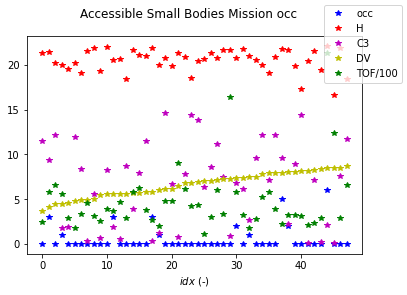

In [77]:
occ = np.zeros(len(data.keys()))
H = np.zeros(len(data.keys()))
C3 = np.zeros(len(data.keys()))
DV = np.zeros(len(data.keys()))
TOF = np.zeros(len(data.keys()))
for profile in range(len(data)):
    occ[profile] = data[str(profile)]['condition_code']
    H[profile] = data[str(profile)]['H']
    C3[profile] = data[str(profile)]['c3_dep']
    DV[profile] = data[str(profile)]['dv_tot']
    TOF[profile] = float(data[str(profile)]['tof'])/100

fig = plt.figure();
plt.plot(occ, "b*");
fig.suptitle('Accessible Small Bodies Mission occ')
plt.xlabel('$idx$ (-)')

plt.plot(H, "r*")
plt.plot(C3, "m*")
plt.plot(DV, "y*")
plt.plot(TOF, "g*")

fig.legend(['occ','H','C3','DV','TOF/100'],loc=1);

In [55]:
records_lim = 100
optim_crit = 0 # meaningfull only if ballistic profile
years = ','.join(map(str, np.linspace(2021,2048,2048-2021+1,dtype=int)))
sb_class = 'pha'
rdzvs = 'true' # meaningfull only if low thrust profile
profile = 2 # meaningfull only if low thrust profile
ball_flag = 0
lt_flag = 1

data_lt = get_accessible_sb(records_lim,optim_crit,years,sb_class,rdzvs,profile,ball_flag,lt_flag)

ConnectionError: HTTPSConnectionPool(host='ssd-api.jpl.nasa.gov', port=443): Max retries exceeded with url: /mdesign.api?lim=100&rdzvs=true&profile=2&year=2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048&sb_class=pha (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x04FF07F0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))

In [ ]:
data_lt

In [19]:
URL = "https://ssd-api.jpl.nasa.gov/mdesign.api?lim=200&rdzvs=true&profile=1&year=2025,2026,2027,2028,2029&sb_class=TJN"
R = requests.get(URL)
DATA = R.json()

In [20]:
DATA

{'message': 'unexpected error: please notify the webmaster', 'code': '500'}